In [1]:
import torch
import numpy as np
import gymnasium as gym

import sys
sys.path.append('../../..')
from tools.trainer import Trainer
from tools.logger import Logger
from environments.hockey_wrapper import HockeyWrapper
from TD3 import TD3Agent
import laserhockey.hockey_env as h_env

In [2]:
env_string = "Hockey"

In [3]:
if env_string == "Hockey":
    env = HockeyWrapper(mode="normal", opponent="weak")
else:
    env = gym.make(env_string)

In [4]:
agent = TD3Agent(env.observation_space, env.action_space)
trainer = Trainer()

In [5]:
player = h_env.BasicOpponent(weak=False)

In [6]:
state = torch.load("checkpoint_hockey.pth")
agent.restore_state(state)
# logger = Logger(30000, 100)
# logger.load("logs/hockey_strong.npy")
# trainer.logger = logger

In [7]:
ep_rewards = trainer.train(env, agent, n_episodes=30000, test_every=100, noise=0.2, player=player, mixed=True)

Step 101/30000:
                    test reward: 2.42
                    mean reward: 1.17, max reward: 11.98
                    Avg. step count: 174.1, Avg ep duration: 0.094s
                    Avg. critic loss: 0.08, Avg. actor loss: 0.61
                    Avg. train duration: 0.350s
                    winrate: 0.25, drawrate: 0.55, lossrate: 0.20
            
Step 201/30000:
                    test reward: 1.86
                    mean reward: -2.57, max reward: 13.37
                    Avg. step count: 169.1, Avg ep duration: 0.091s
                    Avg. critic loss: 0.06, Avg. actor loss: 0.70
                    Avg. train duration: 0.355s
                    winrate: 0.25, drawrate: 0.60, lossrate: 0.15
            
Step 301/30000:
                    test reward: 2.32
                    mean reward: 1.88, max reward: 13.14
                    Avg. step count: 161.3, Avg ep duration: 0.091s
                    Avg. critic loss: 0.06, Avg. actor loss: 0.82
          

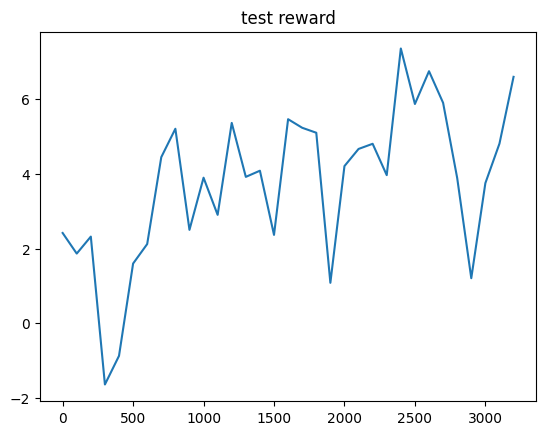

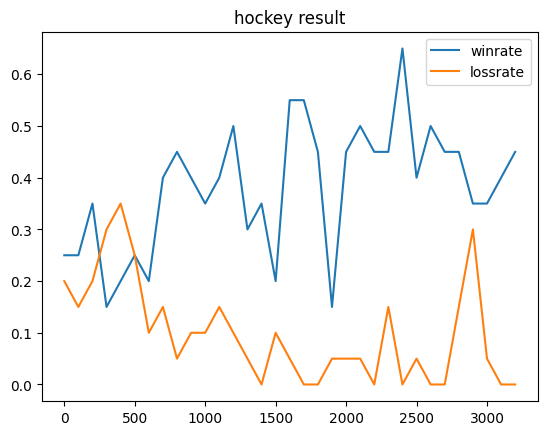

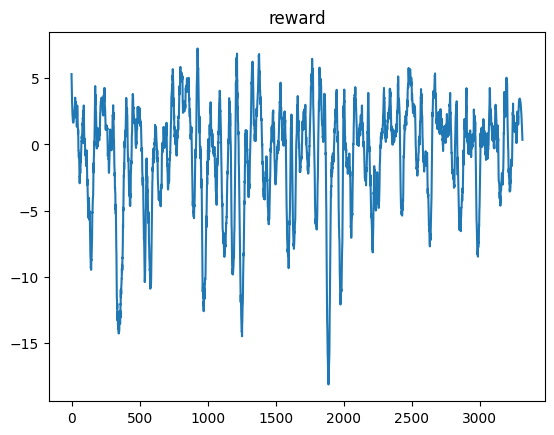

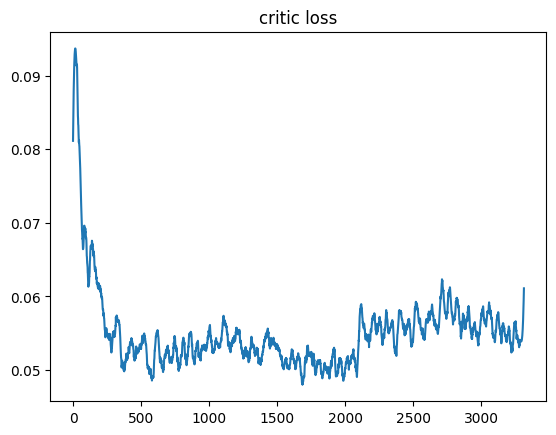

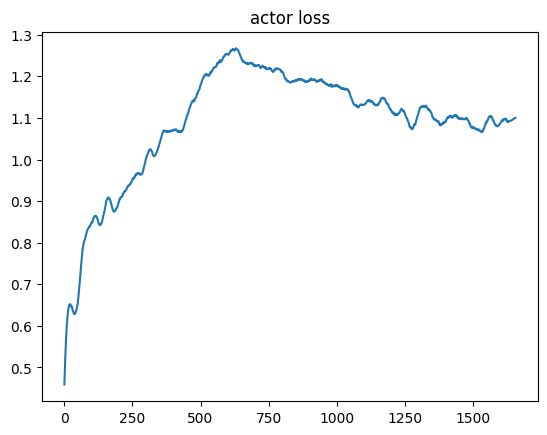

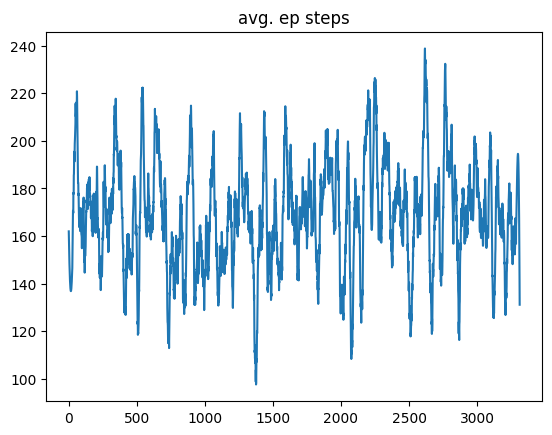

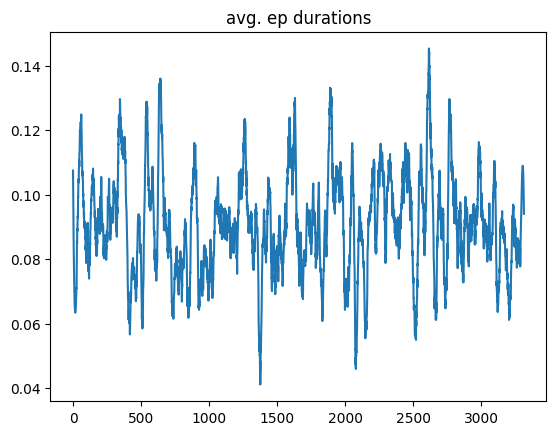

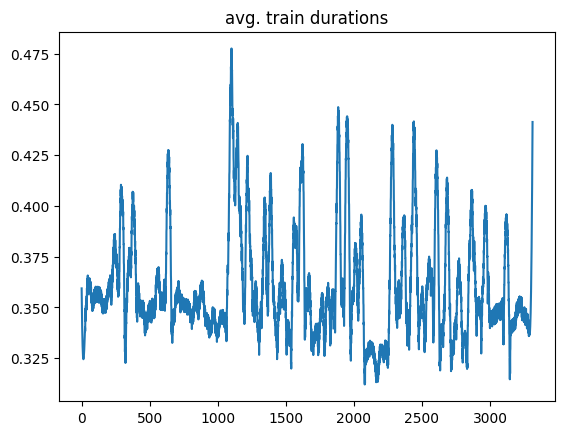

In [8]:
trainer.logger.plot()

In [20]:
def play(env_string, agent, n_episodes=10, noise=0, render=None):
    if env_string == 'Hockey':
        env = HockeyWrapper(mode='normal', opponent='strong')
        if render is None:
            render = True
    else:
        env = gym.make(env_string, render_mode='human')
        render = False
    # player = h_env.BasicOpponent(weak=False)
    player = agent
    steps, rewards, observations, actions, results = Trainer.run(env, player, n_episodes=n_episodes, noise=noise, render=render, store_transitions=False, hockey=env_string=='Hockey')
    env.close()
    return steps, rewards, observations, actions, results

In [21]:
steps, rewards, observations, actions, results = play(env_string, agent, n_episodes=100, noise=0, render=False)
print(np.mean(rewards))
print(np.mean(results==1), np.mean(results==0), np.mean(results==-1))

-0.3812922021431317
0.31 0.42 0.27


In [23]:
# trainer.logger.save("logs/hockey_strong_mixed.npy")

In [22]:
# torch.save(agent.state(), 'checkpoint_hockey.pth')

In [ ]:
# agent_state = torch.load('checkpoint_hockey.pth')
# agent.restore_state(agent_state)